In [1]:
import os
import itertools
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

In [2]:
!pip install kaggle

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download smaranjitghose/corn-or-maize-leaf-disease-dataset

Dataset URL: https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset
License(s): copyright-authors
 96% 154M/161M [00:02<00:00, 75.0MB/s]
100% 161M/161M [00:02<00:00, 73.0MB/s]


In [7]:
!unzip corn-or-maize-leaf-disease-dataset.zip

Archive:  corn-or-maize-leaf-disease-dataset.zip
  inflating: data/Blight/Corn_Blight (1).jpeg  
  inflating: data/Blight/Corn_Blight (1).jpg  
  inflating: data/Blight/Corn_Blight (10).jpg  
  inflating: data/Blight/Corn_Blight (100).jpg  
  inflating: data/Blight/Corn_Blight (1000).JPG  
  inflating: data/Blight/Corn_Blight (1001).JPG  
  inflating: data/Blight/Corn_Blight (1002).JPG  
  inflating: data/Blight/Corn_Blight (1003).JPG  
  inflating: data/Blight/Corn_Blight (1004).JPG  
  inflating: data/Blight/Corn_Blight (1005).JPG  
  inflating: data/Blight/Corn_Blight (1006).JPG  
  inflating: data/Blight/Corn_Blight (1007).JPG  
  inflating: data/Blight/Corn_Blight (1008).JPG  
  inflating: data/Blight/Corn_Blight (1009).JPG  
  inflating: data/Blight/Corn_Blight (101).jpg  
  inflating: data/Blight/Corn_Blight (1010).JPG  
  inflating: data/Blight/Corn_Blight (1011).jpg  
  inflating: data/Blight/Corn_Blight (1012).JPG  
  inflating: data/Blight/Corn_Blight (1013).JPG  
  inflatin

In [8]:
sdir=r'/content/data'


filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths          labels
0  /content/data/Gray_Leaf_Spot/Corn_Gray_Spot (4...  Gray_Leaf_Spot
1  /content/data/Gray_Leaf_Spot/Corn_Gray_Spot (5...  Gray_Leaf_Spot
2  /content/data/Gray_Leaf_Spot/Corn_Gray_Spot (4...  Gray_Leaf_Spot
3  /content/data/Gray_Leaf_Spot/Corn_Gray_Spot (3...  Gray_Leaf_Spot
4  /content/data/Gray_Leaf_Spot/Corn_Gray_Spot (2...  Gray_Leaf_Spot
labels
Common_Rust       1306
Healthy           1162
Blight            1146
Gray_Leaf_Spot     574
Name: count, dtype: int64


In [43]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  3350   test_df length:  419   valid_df length:  419


In [44]:
height=128
width=128
channels=3
batch_size=32

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

gen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

# validgen=ImageDataGenerator(rescale=1./255)
valid_gen=gen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

#testgen=ImageDataGenerator(rescale=1./255)
test_gen=gen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)


test batch size:  1   test steps:  419
Found 3350 validated image filenames belonging to 4 classes.
Found 419 validated image filenames belonging to 4 classes.
Found 419 validated image filenames belonging to 4 classes.
['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


In [11]:
# Assuming `X_train` is the array of training images and `y_train` is the array of corresponding labels
original_images = len(train_df)
augmented_images = len(train_gen)  # X_train_augmented is the array of augmented images

total_images = original_images + augmented_images
augmentation_percentage = (augmented_images / total_images) * 100

print(f"Augmentation percentage: {augmentation_percentage:.2f}%")

Augmentation percentage: 1.55%


In [12]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

In [13]:
show_image_samples(train_gen)

Output hidden; open in https://colab.research.google.com to view.

In [45]:
base_model=tf.keras.applications.MobileNet(include_top=False, weights="imagenet",input_tensor=Input(shape=(128,128,3)))

In [46]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 64, 64, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 64, 64, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 64, 64, 32) 

In [47]:
base_model.trainable = False

In [48]:
model_name='Mobilenetcnn'
print("Building model with", base_model)
model = tf.keras.Sequential([
            # Note the input shape is the desired size of the image 128x128 with 3 bytes color
            # This is the first convolution
            base_model,
            tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
            tf.keras.layers.Dropout(rate=0.5),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),



            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(4, activation='softmax')


])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='categorical_crossentropy', metrics='accuracy')

Building model with <keras.src.engine.functional.Functional object at 0x7cfc3a66d6f0>


In [49]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 4, 4, 1024)        3228864   
 onal)                                                           
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 32)          294944    
                                                                 
 dropout_6 (Dropout)         (None, 4, 4, 32)          0         
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 2, 2, 32)          0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 4)                

In [50]:
epochs =30

history=model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen)

Epoch 1/30
105/105 [==============================] - 68s 634ms/step - loss: 0.7585 - accuracy: 0.7806 - val_loss: 0.3978 - val_accuracy: 0.8377
Epoch 2/30
105/105 [==============================] - 66s 623ms/step - loss: 0.3596 - accuracy: 0.8513 - val_loss: 0.3535 - val_accuracy: 0.8425
Epoch 3/30
105/105 [==============================] - 63s 595ms/step - loss: 0.3143 - accuracy: 0.8675 - val_loss: 0.3311 - val_accuracy: 0.8592
Epoch 4/30
105/105 [==============================] - 66s 630ms/step - loss: 0.2909 - accuracy: 0.8687 - val_loss: 0.3342 - val_accuracy: 0.8735
Epoch 5/30
105/105 [==============================] - 64s 611ms/step - loss: 0.2962 - accuracy: 0.8806 - val_loss: 0.2926 - val_accuracy: 0.8687
Epoch 6/30
105/105 [==============================] - 66s 624ms/step - loss: 0.2793 - accuracy: 0.8896 - val_loss: 0.2872 - val_accuracy: 0.8687
Epoch 7/30
105/105 [==============================] - 68s 647ms/step - loss: 0.2568 - accuracy: 0.8860 - val_loss: 0.3101 - val_ac

In [51]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [52]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

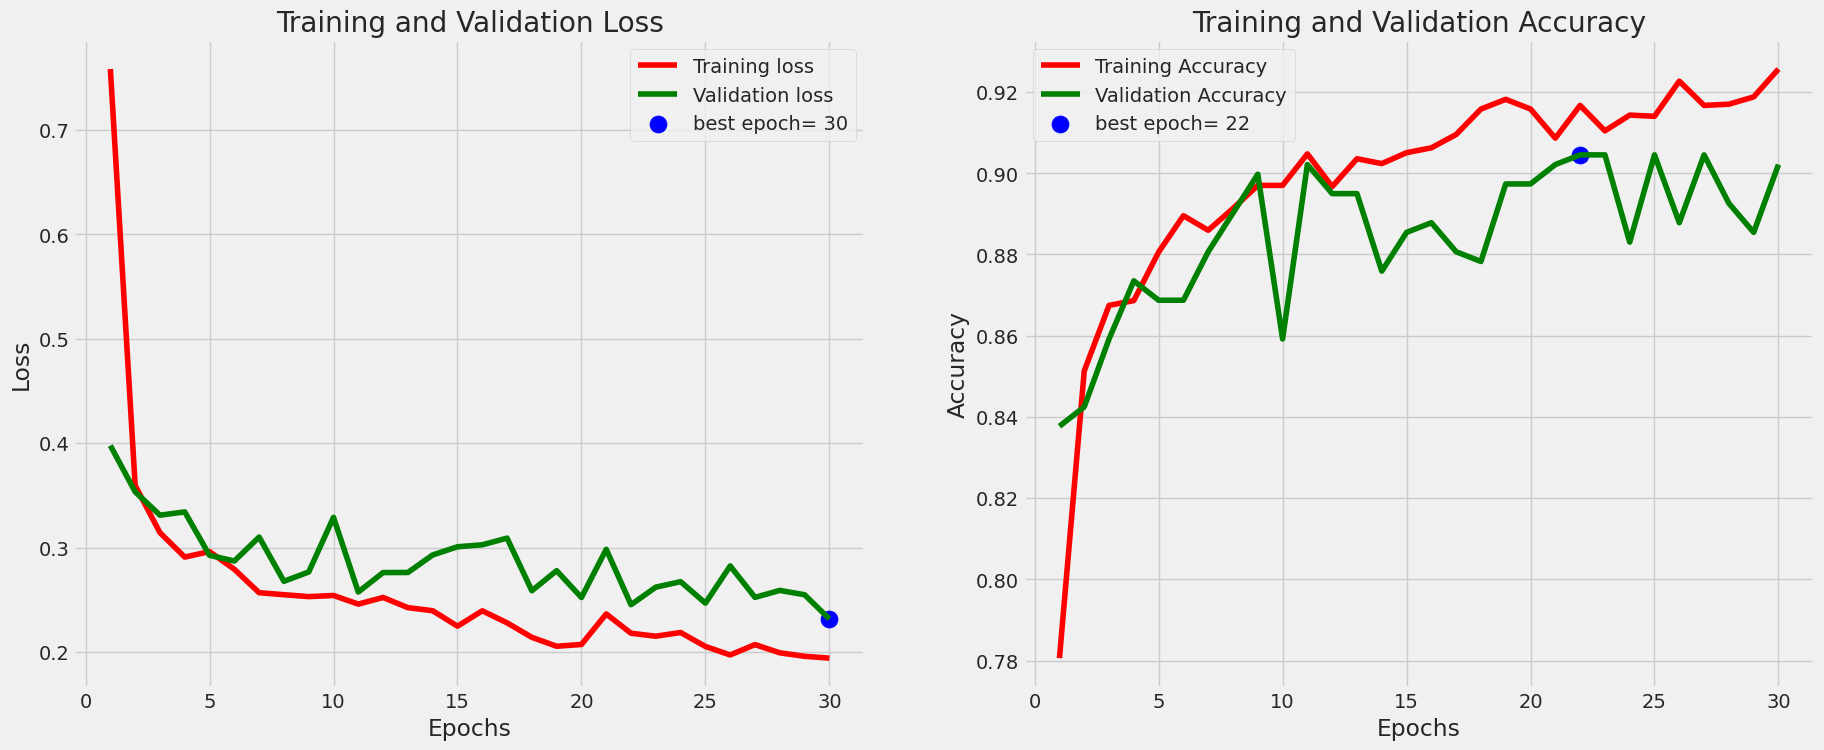

419/419 [==============================] - 11s 27ms/step - loss: 0.2050 - accuracy: 0.9189
accuracy on the test set is 91.89 %



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [53]:
tr_plot(history,0)
save_dir=r'./'
subject='Corn Disease Classification'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

In [54]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'
    dict_path=os.path.join(save_dir,dict_name)
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)
    errors=0
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors=errors + 1
        y_pred.append(pred_index)
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                split1=os.path.split(error_list[i])
                split2=os.path.split(split1[0])
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():
            count=error_indices.count(key)
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix
        cm = confusion_matrix(y_true, y_pred )
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

419/419 [==============================] - 12s 28ms/step


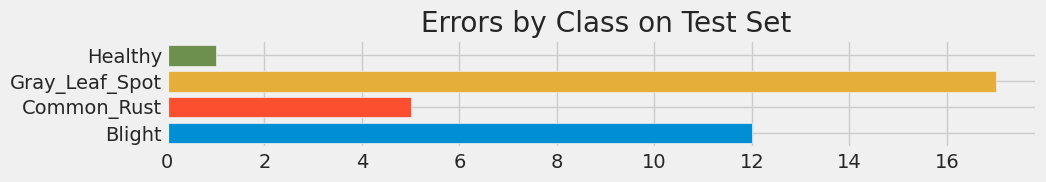

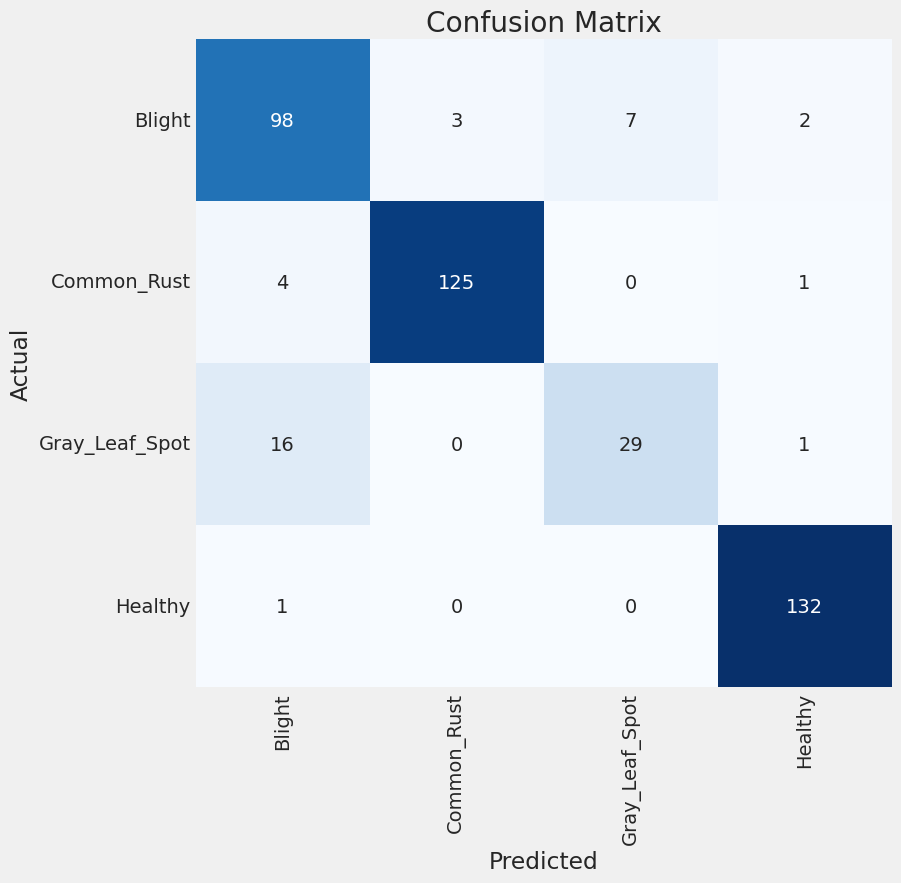

Classification Report:
----------------------
                 precision    recall  f1-score   support

        Blight       0.82      0.89      0.86       110
   Common_Rust       0.98      0.96      0.97       130
Gray_Leaf_Spot       0.81      0.63      0.71        46
       Healthy       0.97      0.99      0.98       133

      accuracy                           0.92       419
     macro avg       0.89      0.87      0.88       419
  weighted avg       0.92      0.92      0.91       419



In [55]:
print_code=0
preds=model.predict(test_gen)
print_info( test_gen, preds, print_code, save_dir, subject )

In [56]:
from keras.models import model_from_json

# Save the model architecture to a JSON file
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

1/1 [==============================] - 0s 97ms/step
Image 1:
  Actual: 2
  Prediction: [[5.1150798e-18 9.3847628e-20 4.7603252e-19 1.0000000e+00]
 [1.6315793e-10 1.0000000e+00 2.0102885e-08 1.3605278e-15]]


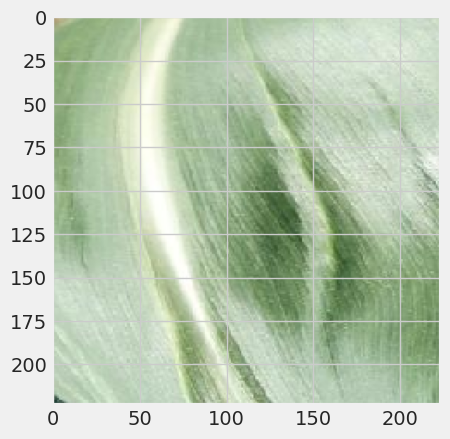

1/1 [==============================] - 0s 90ms/step
Image 2:
  Actual: 0
  Prediction: [[3.5051668e-15 4.6522037e-17 1.2042302e-15 1.0000000e+00]
 [1.3232444e-07 1.2346462e-08 5.0641493e-08 9.9999976e-01]]


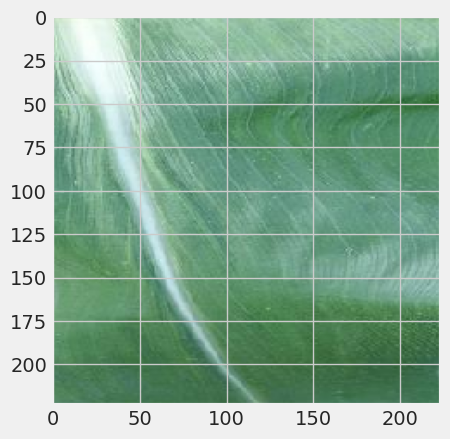

1/1 [==============================] - 0s 86ms/step
Image 3:
  Actual: 3
  Prediction: [[1.7001546e-16 1.0789935e-19 3.9506543e-17 1.0000000e+00]
 [5.9592376e-06 3.1550051e-05 7.2023067e-06 9.9995530e-01]]


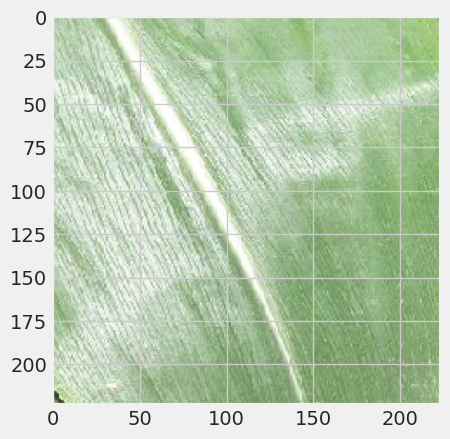

1/1 [==============================] - 0s 86ms/step
Image 4:
  Actual: 3
  Prediction: [[9.5974761e-01 1.6584612e-02 2.3667594e-02 6.8296096e-08]
 [5.6795091e-10 1.0000000e+00 8.9946992e-09 6.0216393e-17]]


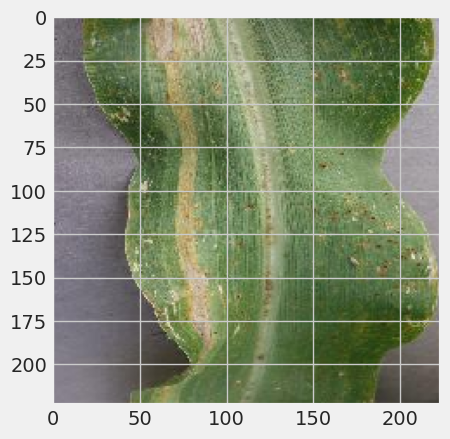

1/1 [==============================] - 0s 100ms/step
Image 5:
  Actual: 1
  Prediction: [[1.1465963e-17 5.1326048e-21 1.0688426e-18 1.0000000e+00]
 [1.5199628e-15 4.8390029e-17 2.8496465e-16 1.0000000e+00]]


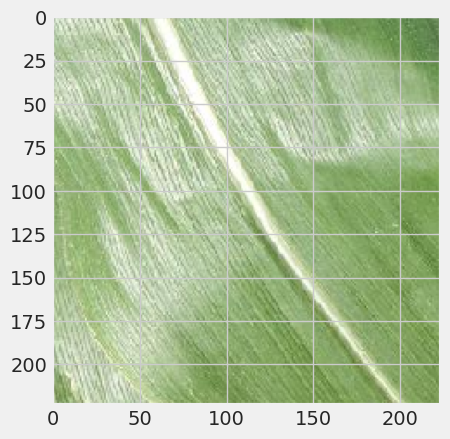

In [ ]:

# Load data testing
test_data =test_gen

# Membuat prediksi pada data testing
predictions = model.predict(test_data)

# Menampilkan beberapa data testing dan prediksinya

for i in range(5):  # Tampilkan 5 data testing
    image, label = next(test_data)
    prediction = model.predict(image)
    print(f"Image {i+1}:")
    print(f"  Actual: {test_data.labels[i]}")
    print(f"  Prediction: {prediction}")
    plt.imshow(image[0])
    plt.show()